# Notebook B — PML setup + tuning (true extension grid)

This notebook treats the PML as a **true extension (collar)** around the physical domain:

- Physical domain: \([0,l_x]\times[0,l_y]\) on a **physical grid**.
- Computational domain: physical domain plus a collar of `npml` cells on each side, on an **extended grid**.
- Medium `c(x,y)` and RHS `f(x,y)` are defined **only on the physical domain**, then **embedded** into the extended grid.
- The PML operator is applied in the collar; the physical domain is untouched.

We tune `(npml, m, eta)` where `strength = eta * omega` (using your `PMLConfig(strength=...)` convention).


In [1]:
from __future__ import annotations

import numpy as np
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

from core.config import HelmholtzConfig, PMLConfig
from core.resolution import (
    grid_from_ppw,
    grid_from_ppw_with_pml_extension,
    embed_physical_field_in_extended,
)
from core.cases import make_default_cases
from core.medium import build_medium

from operators.assemble import assemble_helmholtz_matrix
from operators.pml import build_pml_profiles

from diagnostics import (
    plot_pml_bounds,
    plot_sigma_map,
    plot_solution_with_pml,
)

print("Imports OK")

Imports OK


## 1) Baseline parameters

We fix a physical domain \(l_x,l_y\) and a target PPW, then treat PML as an outer collar.

> Important: `n_min_phys` controls the **physical** grid resolution.  
The extended grid becomes `(n_phys + 2*npml)²`.


In [2]:
# --- Physical PDE / grid ---
omega = 32.0
ppw_target = 10.0
lx, ly = 1.0, 1.0
n_min_phys = 501
make_odd_phys = True
c_min_for_grid = 1.0
case_name = "const"

# --- RHS (Gaussian source on physical domain) ---
gauss_sigma = 0.05
gauss_amp = 1.0

# --- Initial PML guess (collar thickness is part of grid extension) ---
npml0 = 30
m0 = 3
eta0 = 8.0
strength0 = eta0 * omega

print("Baseline parameters set.")

Baseline parameters set.


## 2) Build physical + extended grids

We build:
- `grid_phys`: used to *define* medium and RHS.
- `grid_ext` : used for the *PML solve*.

`core_slices = (si, sj)` tells where the physical domain lives inside the extended arrays.


In [3]:
ext0 = grid_from_ppw_with_pml_extension(
    omega=omega,
    ppw=ppw_target,
    lx=lx,
    ly=ly,
    npml=npml0,
    c_min=c_min_for_grid,
    n_min_phys=n_min_phys,
    make_odd_phys=make_odd_phys,
)

grid_phys = ext0.grid_phys
grid_ext  = ext0.grid_ext
si, sj    = ext0.core_slices

print(f"Physical grid:  {grid_phys.nx} x {grid_phys.ny}, h≈{max(grid_phys.hx, grid_phys.hy):.4g}")
print(f"Extended grid:  {grid_ext.nx} x {grid_ext.ny}, h≈{max(grid_ext.hx, grid_ext.hy):.4g}")
print(f"PML collar: npml={npml0} nodes -> thickness≈{npml0*max(grid_phys.hx, grid_phys.hy):.4g}")

Physical grid:  501 x 501, h≈0.002
Extended grid:  561 x 561, h≈0.002
PML collar: npml=30 nodes -> thickness≈0.06


## 3) Build medium `c` on physical grid and embed into extended grid

Recommendation (robust): fill the collar with a constant reference speed `c_ref` (e.g. `min(c_phys)`).


In [4]:
cases = make_default_cases()
if hasattr(cases, "keys"):
    case_cfg = cases.get(case_name, list(cases.values())[0])
else:
    case_cfg = next(cc for cc in cases if getattr(cc, "name", None) == case_name)

cfg_phys = HelmholtzConfig(omega=omega, grid=grid_phys, pml=None)

X_phys, Y_phys = grid_phys.mesh()
c_phys = build_medium(cfg_phys, case_cfg, X_phys, Y_phys)

c_ref = float(np.min(c_phys))
c_ext = embed_physical_field_in_extended(
    c_phys,
    ext_shape=(grid_ext.nx, grid_ext.ny),
    core_slices=(si, sj),
    fill_value=c_ref,
    dtype=float,
)

print("c_phys min/max:", float(np.min(c_phys)), float(np.max(c_phys)))
print("c_ext  min/max:", float(np.min(c_ext)), float(np.max(c_ext)))

c_phys min/max: 1.0 1.0
c_ext  min/max: 1.0 1.0


## 4) Build RHS on physical grid and embed into extended grid

We keep RHS zero in the collar.


In [5]:
def gaussian_rhs(X, Y, x0, y0, sigma=0.05, amp=1.0):
    g = amp * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2*sigma**2))
    return g

x0, y0 = 0.5*lx, 0.5*ly
f_phys_2d = gaussian_rhs(X_phys, Y_phys, x0, y0, sigma=gauss_sigma, amp=gauss_amp)

f_ext_2d = embed_physical_field_in_extended(
    f_phys_2d,
    ext_shape=(grid_ext.nx, grid_ext.ny),
    core_slices=(si, sj),
    fill_value=0.0,
    dtype=float,
)

f_phys = f_phys_2d.reshape(-1)
f_ext  = f_ext_2d.reshape(-1)

print("f_phys shape:", f_phys.shape, "f_ext shape:", f_ext.shape)

f_phys shape: (251001,) f_ext shape: (314721,)


## 5) PML profiles sanity check (geometry + sigma)

This checks that:
- sigma ramps only in the outer collar,
- stretch factors are 1 in the physical region,
- visualization shows where the collar sits relative to the physical domain.


max sigma_x interior: 0.0
max sigma_y interior: 0.0
max |sx-1| interior: 0.0
max |sy-1| interior: 0.0
npml*h = 0.06
max sigma = 256.0
max Im(s) = 8.0


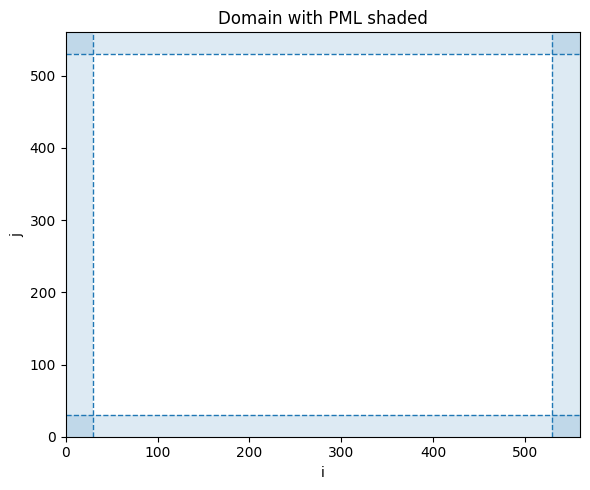

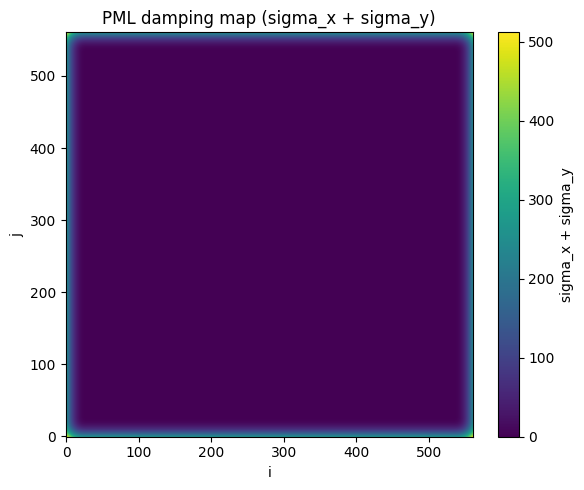

In [6]:
cfg_pml0 = HelmholtzConfig(
    omega=omega,
    grid=grid_ext,
    pml=PMLConfig(thickness=npml0, power=m0, strength=float(strength0)),
)

sig_x, sig_y, sx, sy = build_pml_profiles(cfg_pml0, c_ref=c_ref)

# interior sanity (physical region should be sigma=0 -> s=1)
sigx_in = sig_x[npml0:-npml0]
sigy_in = sig_y[npml0:-npml0]
sx_in = sx[npml0:-npml0]
sy_in = sy[npml0:-npml0]

print("max sigma_x interior:", float(np.max(sigx_in)))
print("max sigma_y interior:", float(np.max(sigy_in)))
print("max |sx-1| interior:", float(np.max(np.abs(sx_in - 1))))
print("max |sy-1| interior:", float(np.max(np.abs(sy_in - 1))))

print("npml*h =", npml0 * max(grid_ext.hx, grid_ext.hy))
print("max sigma =", float(max(sig_x.max(), sig_y.max())))
print("max Im(s) =", float(max(np.max(np.imag(sx)), np.max(np.imag(sy)))))

plot_pml_bounds(cfg_pml0, show=True)
plot_sigma_map(cfg_pml0, sig_x, sig_y, show=True)

## 6) Solve: Dirichlet on physical domain vs PML on extended domain

- Dirichlet solve is done on `grid_phys` with your baseline identity rows.
- PML solve is done on `grid_ext` with collar absorption.

For comparison, we also extract the PML solution **restricted to the physical slice**.


||u_dir||2 = 0.3026540148553955
||u_pml||2 = 0.17547042679330618
||u_pml_phys||2 = 0.16342666223531377


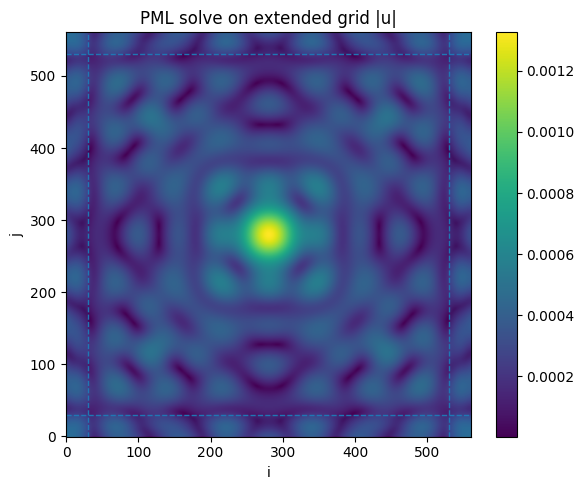

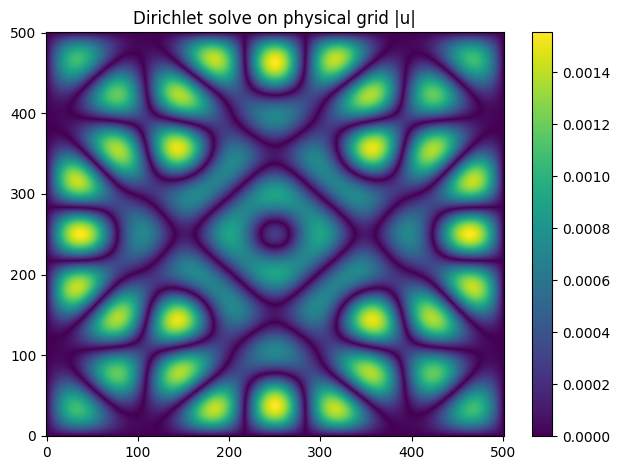

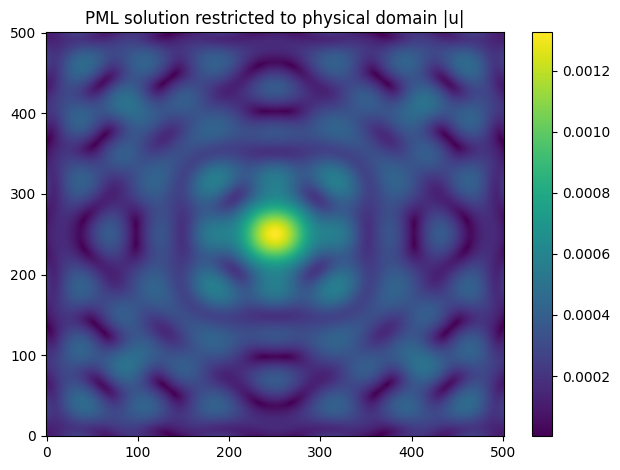

In [7]:
# Dirichlet (physical domain)
A_dir = assemble_helmholtz_matrix(cfg_phys, c_phys)
u_dir = spla.spsolve(A_dir, f_phys)
U_dir = u_dir.reshape(grid_phys.nx, grid_phys.ny)

# PML (extended domain)
A_pml = assemble_helmholtz_matrix(cfg_pml0, c_ext)
u_pml = spla.spsolve(A_pml, f_ext)
U_pml = u_pml.reshape(grid_ext.nx, grid_ext.ny)

# Restrict PML solution to physical domain
U_pml_phys = U_pml[si, sj]

print("||u_dir||2 =", float(np.linalg.norm(u_dir)))
print("||u_pml||2 =", float(np.linalg.norm(u_pml)))
print("||u_pml_phys||2 =", float(np.linalg.norm(U_pml_phys.reshape(-1))))

# Visuals
plot_solution_with_pml(cfg_pml0, u_pml, title="PML solve on extended grid |u|", show=True)

plt.figure()
plt.imshow(np.abs(U_dir).T, origin="lower", aspect="auto")
plt.colorbar()
plt.title("Dirichlet solve on physical grid |u|")
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(np.abs(U_pml_phys).T, origin="lower", aspect="auto")
plt.colorbar()
plt.title("PML solution restricted to physical domain |u|")
plt.tight_layout()
plt.show()


## 7) Metrics that respect the physical domain

Your original `reflection_metrics(U, npml=...)` is designed for the *in-grid PML ring* case.
Here, we use a simpler metric on the **physical domain array**:

- `core_max`: max |u| in the interior excluding a `band` near boundary
- `iface_max`: max |u| in the boundary band
- ratio `iface/core`: smaller is better


In [8]:
def reflection_metrics_physical(U_phys: np.ndarray, band: int = 5) -> dict:
    nx, ny = U_phys.shape
    if band < 1:
        raise ValueError("band must be >= 1")
    if 2*band >= min(nx, ny):
        raise ValueError("band too large for this grid")

    A = np.abs(U_phys)

    core = A[band:-band, band:-band]
    core_max = float(np.max(core))

    # boundary band: union of top/bottom/left/right strips
    top = A[:, -band:]
    bot = A[:, :band]
    left = A[:band, :]
    right = A[-band:, :]
    iface_max = float(max(np.max(top), np.max(bot), np.max(left), np.max(right)))

    return {"core_max": core_max, "iface_max": iface_max, "iface/core": iface_max / (core_max + 1e-30)}

met_dir = reflection_metrics_physical(U_dir, band=5)
met_pml = reflection_metrics_physical(U_pml_phys, band=5)

print("Dirichlet metrics (physical):", met_dir)
print("PML metrics (physical):", met_pml)

Dirichlet metrics (physical): {'core_max': 0.0015533727096941324, 'iface_max': 0.00027338699720578, 'iface/core': 0.17599575137354603}
PML metrics (physical): {'core_max': 0.0013258887726632755, 'iface_max': 0.00025774118088159727, 'iface/core': 0.1943912537730294}


## 8) Guardrail: radial profile on the physical domain

We confirm that waves propagate in the physical domain (no global overdamping).


In [9]:
def radial_profile_abs(U, i0, j0, radii, dr=2):
    I, J = np.indices(U.shape)
    R = np.sqrt((I - i0)**2 + (J - j0)**2)
    prof = []
    for r in radii:
        mask = (R >= r-dr) & (R <= r+dr)
        prof.append(np.mean(np.abs(U[mask])))
    return np.array(prof)

i0 = grid_phys.nx // 2
j0 = grid_phys.ny // 2
radii = [10, 30, 60, 100, 150, 200]

p_dir = radial_profile_abs(U_dir, i0, j0, radii)
p_pml = radial_profile_abs(U_pml_phys, i0, j0, radii)

print("r, |u| Dirichlet:", list(zip(radii, p_dir)))
print("r, |u| PML (phys slice):", list(zip(radii, p_pml)))

r, |u| Dirichlet: [(10, np.float64(0.00015146351327910952)), (30, np.float64(0.0005121777680710959)), (60, np.float64(0.000551065701547997)), (100, np.float64(0.000508057142028315)), (150, np.float64(0.0005149660170321598)), (200, np.float64(0.0006914798966080446))]
r, |u| PML (phys slice): [(10, np.float64(0.0012595110699047194)), (30, np.float64(0.0008711136016236754)), (60, np.float64(0.00040328964011384456)), (100, np.float64(0.000334234414081839)), (150, np.float64(0.00028086960130634906)), (200, np.float64(0.00027077190691788384))]


## 9) Tuning sweeps

Because PML is a **true extension**, changing `npml` changes the *grid size*.
So for the `npml` sweep we rebuild the extended grid and re-embed `c` and `f`.

We keep the physical grid fixed across all sweeps.


In [ ]:
def solve_pml_extended(npml: int, m: int, eta: float):
    # build extended grid for this npml
    ext = grid_from_ppw_with_pml_extension(
        omega=omega, ppw=ppw_target, lx=lx, ly=ly, npml=int(npml),
        c_min=c_min_for_grid, n_min_phys=n_min_phys, make_odd_phys=make_odd_phys
    )
    gext = ext.grid_ext
    si_, sj_ = ext.core_slices

    # embed c and f
    c_ext_ = embed_physical_field_in_extended(
        c_phys, ext_shape=(gext.nx, gext.ny), core_slices=(si_, sj_), fill_value=c_ref, dtype=float
    )
    f_ext_ = embed_physical_field_in_extended(
        f_phys_2d, ext_shape=(gext.nx, gext.ny), core_slices=(si_, sj_), fill_value=0.0, dtype=float
    ).reshape(-1)

    strength = float(eta * omega)
    cfg = HelmholtzConfig(
        omega=omega, grid=gext,
        pml=PMLConfig(thickness=int(npml), power=int(m), strength=strength),
    )

    A = assemble_helmholtz_matrix(cfg, c_ext_)
    u = spla.spsolve(A, f_ext_)
    U = u.reshape(gext.nx, gext.ny)
    U_phys = U[si_, sj_]

    met = reflection_metrics_physical(U_phys, band=5)
    return met, float(np.linalg.norm(U_phys)), U_phys

# --- eta fine sweep (fixed npml0, m0) ---
etas_fine = [3, 4, 5, 6, 7, 8, 10, 12, 15]
eta_results = []
for eta in etas_fine:
    met, norm_phys, _ = solve_pml_extended(npml0, m0, eta)
    # mid-radius proxy: r=100 average
    mid = float(radial_profile_abs(U_pml_phys, i0, j0, [100])[0]) if 'U_pml_phys' in globals() else np.nan
    eta_results.append((eta, met["iface/core"], met["iface_max"], met["core_max"], norm_phys))

print("eta, iface/core, iface_max, core_max, ||u_phys||2")
for r in eta_results:
    print(r)

eta, iface/core, iface_max, core_max, ||u_phys||2
(3, 0.2454127296442632, 0.0002992449309647102, 0.0012193537450093939, 0.19801246261319225)
(4, 0.2005646298276698, 0.0002554487185602441, 0.0012736478948443307, 0.1872417018277901)
(5, 0.186944130424957, 0.00024307109220429761, 0.0013002338808485408, 0.17848834767100885)
(6, 0.18480165488051387, 0.00024265419753361078, 0.0013130520811109744, 0.17182336366175396)
(8, 0.1943912537730294, 0.00025774118088159727, 0.0013258887726632755, 0.16342666223531377)
(10, 0.20368511634396896, 0.0002725501620646097, 0.0013380956201254604, 0.15929975137696276)
(12, 0.2119475244412228, 0.00028686338878456416, 0.0013534642102607667, 0.15755242549731366)
(15, 0.22197052370550616, 0.0003064274037043673, 0.0013804869159605724, 0.15722745836187846)


### npml sweep (fixed m and eta*)

Pick an `eta_star` from the sweep above (often 6–10).


In [15]:
eta_star = 6.0  # update after reviewing eta_results
npml_list = [20, 30, 35, 40, 45, 50]
npml_results = []

for npml in npml_list:
    met, norm_phys, _ = solve_pml_extended(npml, m0, eta_star)
    npml_results.append((npml, met["iface/core"], met["iface_max"], met["core_max"], norm_phys))

print("npml, iface/core, iface_max, core_max, ||u_phys||2")
for r in npml_results:
    print(r)

npml, iface/core, iface_max, core_max, ||u_phys||2
(20, 0.3474645485347434, 0.0004763008625304188, 0.0013707898101805714, 0.16929008235801268)
(30, 0.18480165488051387, 0.00024265419753361078, 0.0013130520811109744, 0.17182336366175396)
(35, 0.16248000284046638, 0.00021832373508933289, 0.0013436960319584534, 0.16114130144673308)
(40, 0.15262631512221927, 0.00021154591817594586, 0.001386038298877525, 0.15699437936595162)
(45, 0.16241156055548986, 0.0002239802919622929, 0.0013790908183889247, 0.15336363685884732)
(50, 0.1747855853358581, 0.00023832172128986128, 0.001363509014956329, 0.15166321182014947)


### m sweep (fixed npml* and eta*)

In [ ]:
npml_star = 40  # update from npml_results
m_list = [2, 2.25, 2.50, 2.75, 3, 3.25, 3.5, 3.75, 4]
m_results = []

for m in m_list:
    met, norm_phys, _ = solve_pml_extended(npml_star, m, eta_star)
    m_results.append((m, met["iface/core"], met["iface_max"], met["core_max"], norm_phys))

print("m, iface/core, iface_max, core_max, ||u_phys||2")
for r in m_results:
    print(r)

m, iface/core, iface_max, core_max, ||u_phys||2
(2, 0.17985808897687247, 0.00025009049541886355, 0.0013904878943255207, 0.1521689037960025)
(3, 0.15388213516510013, 0.00020781635574324898, 0.0013504904615489176, 0.1539708364287686)
(4, 0.17642437273023429, 0.0002466945690685987, 0.0013983020897334446, 0.16386737019108802)


## 10) Recommended settings printout

In [13]:
eta_rec = eta_star
npml_rec = npml_star
m_rec = 3

print("=== RECOMMENDED PML SETTINGS (true extension) ===")
print("omega =", omega)
print("physical grid =", grid_phys.nx, "x", grid_phys.ny)
print("npml  =", npml_rec)
print("m     =", m_rec)
print("eta   =", eta_rec, " (strength = eta*omega)")
print("strength =", float(eta_rec * omega))
print("==============================================")

=== RECOMMENDED PML SETTINGS (true extension) ===
omega = 32.0
physical grid = 501 x 501
npml  = 40
m     = 3
eta   = 8.0  (strength = eta*omega)
strength = 256.0


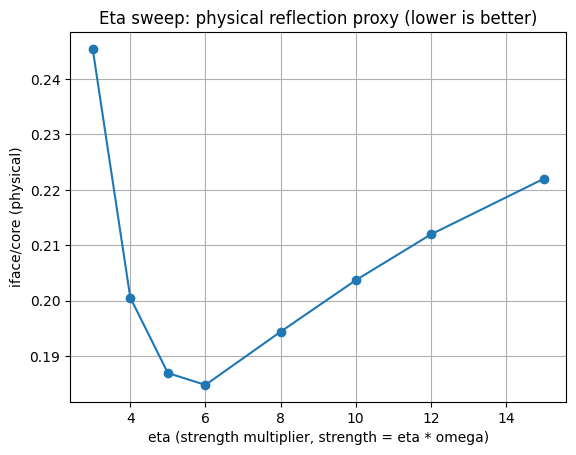

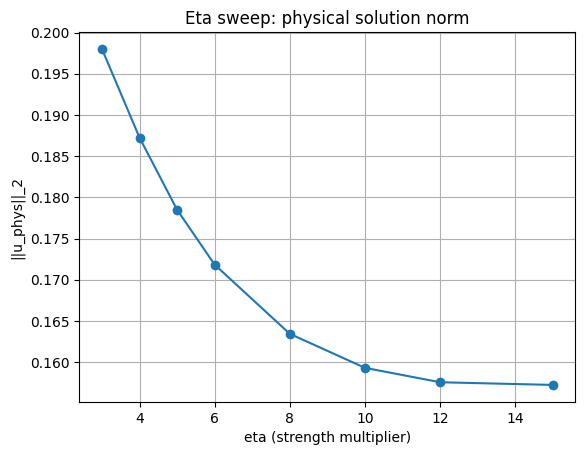

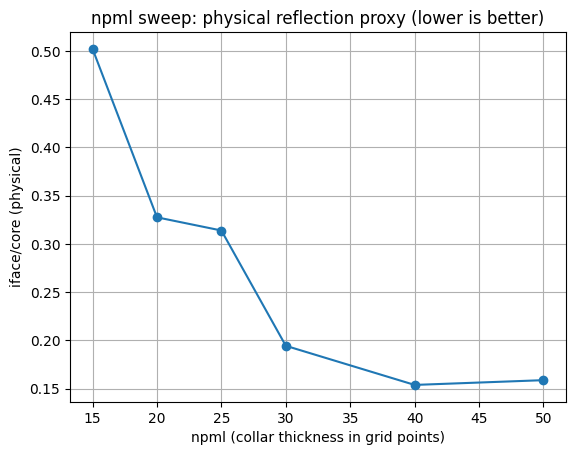

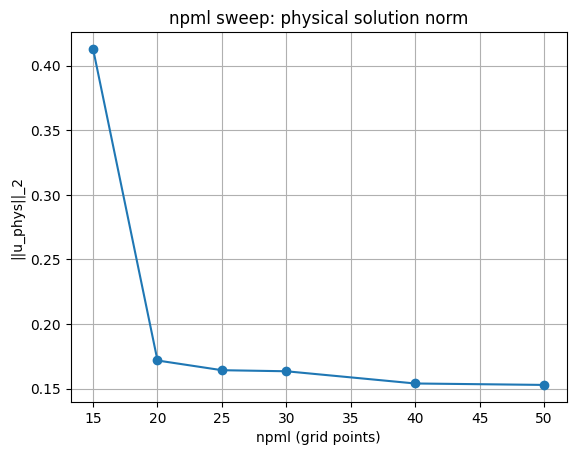

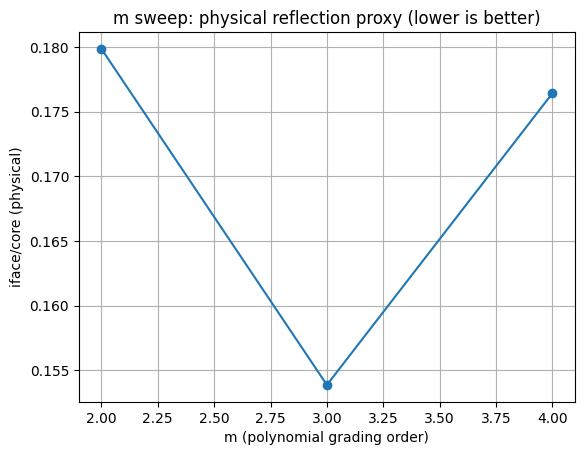

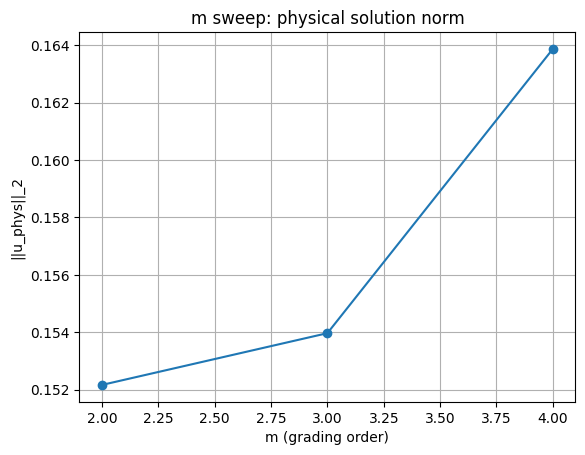

In [16]:
# Visualize PML tuning sweep results (eta, npml, m)
import numpy as np
import matplotlib.pyplot as plt

# --- Paste your sweep outputs here (as lists of tuples) ---
eta_results = [
    (3, 0.2454127296442632, 0.0002992449309647102, 0.0012193537450093939, 0.19801246261319225),
    (4, 0.2005646298276698, 0.0002554487185602441, 0.0012736478948443307, 0.1872417018277901),
    (5, 0.186944130424957, 0.00024307109220429761, 0.0013002338808485408, 0.17848834767100885),
    (6, 0.18480165488051387, 0.00024265419753361078, 0.0013130520811109744, 0.17182336366175396),
    (8, 0.1943912537730294, 0.00025774118088159727, 0.0013258887726632755, 0.16342666223531377),
    (10, 0.20368511634396896, 0.0002725501620646097, 0.0013380956201254604, 0.15929975137696276),
    (12, 0.2119475244412228, 0.00028686338878456416, 0.0013534642102607667, 0.15755242549731366),
    (15, 0.22197052370550616, 0.0003064274037043673, 0.0013804869159605724, 0.15722745836187846),
]

npml_results = [
    (15, 0.5019530295521488, 0.0015233214881706356, 0.003034788911483948, 0.41298334440782286),
    (20, 0.32750109100195546, 0.00046806851360297436, 0.0014292120742894856, 0.17176662362765338),
    (25, 0.3138394219339364, 0.00036547903152601654, 0.0011645415011086477, 0.16425334470923006),
    (30, 0.1943912537730294, 0.00025774118088159727, 0.0013258887726632755, 0.16342666223531377),
    (40, 0.15388213516510013, 0.00020781635574324898, 0.0013504904615489176, 0.1539708364287686),
    (50, 0.15880978773459034, 0.00021452037277251625, 0.001350800702101761, 0.1528566389604549),
]

m_results = [
    (2, 0.17985808897687247, 0.00025009049541886355, 0.0013904878943255207, 0.1521689037960025),
    (3, 0.15388213516510013, 0.00020781635574324898, 0.0013504904615489176, 0.1539708364287686),
    (4, 0.17642437273023429, 0.0002466945690685987, 0.0013983020897334446, 0.16386737019108802),
]

# --- Helper to unpack ---
def unpack(rows):
    x = np.array([r[0] for r in rows], dtype=float)
    iface_core = np.array([r[1] for r in rows], dtype=float)
    iface_max = np.array([r[2] for r in rows], dtype=float)
    core_max = np.array([r[3] for r in rows], dtype=float)
    u_norm = np.array([r[4] for r in rows], dtype=float)
    return x, iface_core, iface_max, core_max, u_norm

# --- Plot 1: eta sweep (iface/core + ||u||) ---
x, iface_core, iface_max, core_max, u_norm = unpack(eta_results)

plt.figure()
plt.plot(x, iface_core, marker="o")
plt.xlabel("eta (strength multiplier, strength = eta * omega)")
plt.ylabel("iface/core (physical)")
plt.title("Eta sweep: physical reflection proxy (lower is better)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(x, u_norm, marker="o")
plt.xlabel("eta (strength multiplier)")
plt.ylabel("||u_phys||_2")
plt.title("Eta sweep: physical solution norm")
plt.grid(True)
plt.show()

# --- Plot 2: npml sweep ---
x, iface_core, iface_max, core_max, u_norm = unpack(npml_results)

plt.figure()
plt.plot(x, iface_core, marker="o")
plt.xlabel("npml (collar thickness in grid points)")
plt.ylabel("iface/core (physical)")
plt.title("npml sweep: physical reflection proxy (lower is better)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(x, u_norm, marker="o")
plt.xlabel("npml (grid points)")
plt.ylabel("||u_phys||_2")
plt.title("npml sweep: physical solution norm")
plt.grid(True)
plt.show()

# --- Plot 3: m sweep ---
x, iface_core, iface_max, core_max, u_norm = unpack(m_results)

plt.figure()
plt.plot(x, iface_core, marker="o")
plt.xlabel("m (polynomial grading order)")
plt.ylabel("iface/core (physical)")
plt.title("m sweep: physical reflection proxy (lower is better)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(x, u_norm, marker="o")
plt.xlabel("m (grading order)")
plt.ylabel("||u_phys||_2")
plt.title("m sweep: physical solution norm")
plt.grid(True)
plt.show()


## 11) 3D sweep

In [17]:
# 3D grid search over (npml, eta, m) and print the best result
import numpy as np
import time

# Search grids
npml_grid = [35, 40, 45]
eta_grid  = [5, 6, 7]
m_grid    = [2, 3, 4]

# Safety: ensure the solver function exists
if "solve_pml_extended" not in globals():
    raise NameError(
        "solve_pml_extended(...) not found in globals. "
        "Define it first (it should return (met, norm_phys, U_phys) or similar)."
    )

def _iface_over_core(met: dict) -> float:
    val = float(met.get("iface/core", np.nan))
    return val

results = []
t0 = time.time()

best = None
best_key = None

print("Running 3D sweep over:")
print("  npml =", npml_grid)
print("  eta  =", eta_grid)
print("  m    =", m_grid)
print("Metric: minimize iface/core (physical)\n")

for npml in npml_grid:
    for eta in eta_grid:
        for m in m_grid:
            met, norm_phys, _ = solve_pml_extended(npml=npml, m=m, eta=eta)
            key = _iface_over_core(met)

            row = {
                "npml": int(npml),
                "eta": float(eta),
                "m": int(m),
                "iface/core": float(key),
                "iface_max": float(met.get("iface_max", np.nan)),
                "core_max": float(met.get("core_max", np.nan)),
                "||u_phys||2": float(norm_phys),
            }
            results.append(row)

            print(f"(npml={npml:>2}, eta={eta:>2}, m={m}) -> iface/core={row['iface/core']:.6g}")

            if best is None or row["iface/core"] < best["iface/core"]:
                best = row
                best_key = (npml, eta, m)

dt = time.time() - t0

# Print best summary
print("\n=== BEST RESULT (min iface/core) ===")
print(f"npml = {best['npml']}")
print(f"eta  = {best['eta']}")
print(f"m    = {best['m']}")
print(f"iface/core = {best['iface/core']:.6g}")
print(f"iface_max  = {best['iface_max']:.6g}")
print(f"core_max   = {best['core_max']:.6g}")
print(f"||u_phys||2 = {best['||u_phys||2']:.6g}")

# If you want the implied strength too (given your convention strength = eta*omega)
if "omega" in globals():
    strength = float(best["eta"] * float(omega))
    print(f"strength (=eta*omega) = {strength:.6g}")

print(f"Total solves: {len(results)} | elapsed: {dt:.2f}s")
print("===================================")


Running 3D sweep over:
  npml = [35, 40, 45]
  eta  = [5, 6, 7]
  m    = [2, 3, 4]
Metric: minimize iface/core (physical)

(npml=35, eta= 5, m=2) -> iface/core=0.156285
(npml=35, eta= 5, m=3) -> iface/core=0.177583
(npml=35, eta= 5, m=4) -> iface/core=0.261805
(npml=35, eta= 6, m=2) -> iface/core=0.166653
(npml=35, eta= 6, m=3) -> iface/core=0.16248
(npml=35, eta= 6, m=4) -> iface/core=0.22942
(npml=35, eta= 7, m=2) -> iface/core=0.176171
(npml=35, eta= 7, m=3) -> iface/core=0.154645
(npml=35, eta= 7, m=4) -> iface/core=0.203675
(npml=40, eta= 5, m=2) -> iface/core=0.152503
(npml=40, eta= 5, m=3) -> iface/core=0.170097
(npml=40, eta= 5, m=4) -> iface/core=0.235832
(npml=40, eta= 6, m=2) -> iface/core=0.162905
(npml=40, eta= 6, m=3) -> iface/core=0.152626
(npml=40, eta= 6, m=4) -> iface/core=0.209742
(npml=40, eta= 7, m=2) -> iface/core=0.172047
(npml=40, eta= 7, m=3) -> iface/core=0.148475
(npml=40, eta= 7, m=4) -> iface/core=0.190729
(npml=45, eta= 5, m=2) -> iface/core=0.153762
(npml

=== Global best (min iface/core) ===
npml=40, eta=7, m=3, iface/core=0.148475


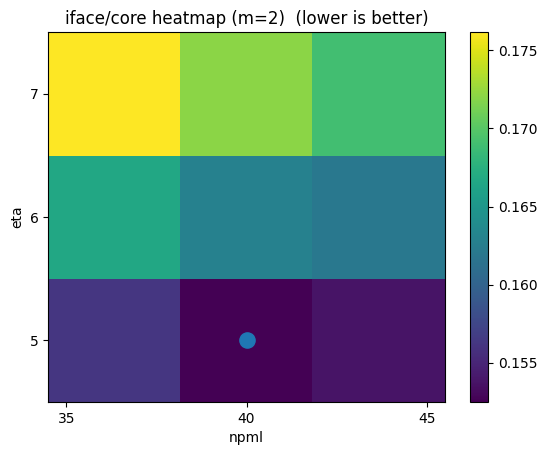

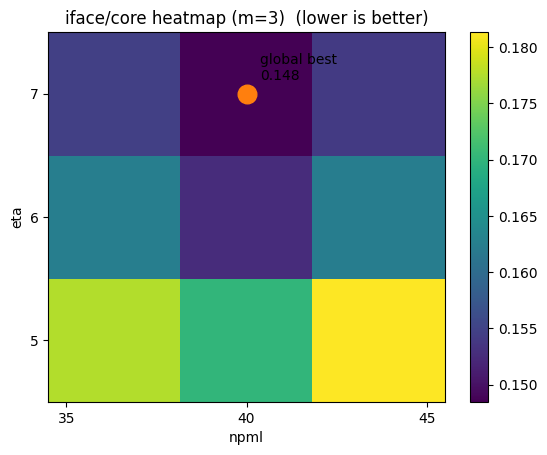

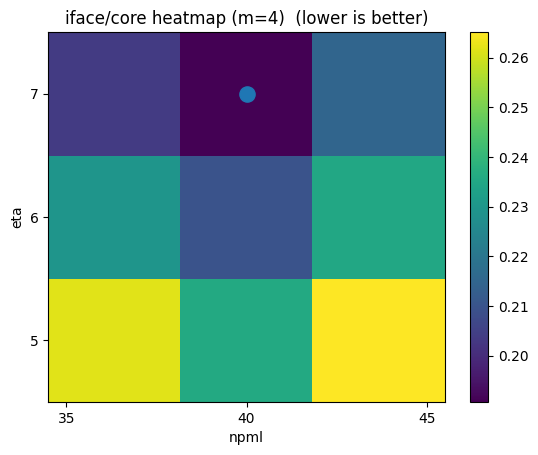

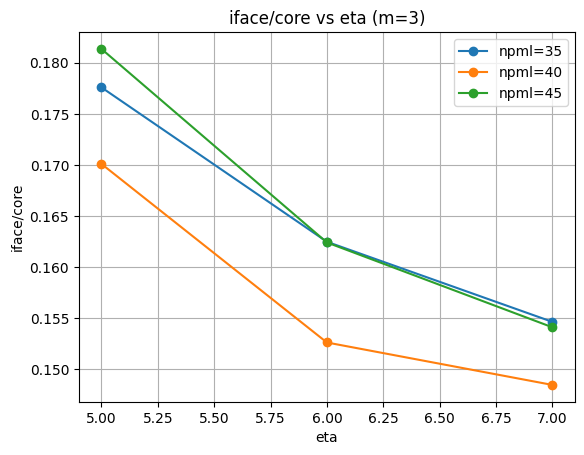

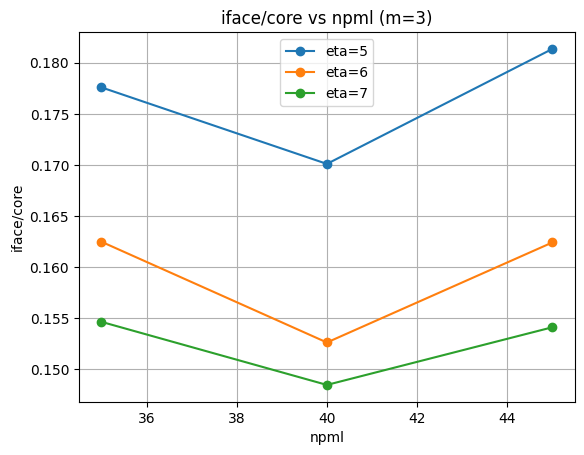

In [18]:
# Visualize 3D sweep (npml, eta, m) as heatmaps + summary line plots
import numpy as np
import matplotlib.pyplot as plt

# Paste your sweep results here as a list of dicts or tuples.
# Easiest: reconstruct from the printed table (npml, eta, m, iface/core).
rows = [
    (35, 5, 2, 0.156285),
    (35, 5, 3, 0.177583),
    (35, 5, 4, 0.261805),
    (35, 6, 2, 0.166653),
    (35, 6, 3, 0.16248),
    (35, 6, 4, 0.22942),
    (35, 7, 2, 0.176171),
    (35, 7, 3, 0.154645),
    (35, 7, 4, 0.203675),

    (40, 5, 2, 0.152503),
    (40, 5, 3, 0.170097),
    (40, 5, 4, 0.235832),
    (40, 6, 2, 0.162905),
    (40, 6, 3, 0.152626),
    (40, 6, 4, 0.209742),
    (40, 7, 2, 0.172047),
    (40, 7, 3, 0.148475),
    (40, 7, 4, 0.190729),

    (45, 5, 2, 0.153762),
    (45, 5, 3, 0.181346),
    (45, 5, 4, 0.265164),
    (45, 6, 2, 0.161957),
    (45, 6, 3, 0.162412),
    (45, 6, 4, 0.235477),
    (45, 7, 2, 0.169041),
    (45, 7, 3, 0.154115),
    (45, 7, 4, 0.214932),
]

npmls = sorted({r[0] for r in rows})
etas  = sorted({r[1] for r in rows})
ms    = sorted({r[2] for r in rows})

npml_to_i = {v:i for i,v in enumerate(npmls)}
eta_to_j  = {v:j for j,v in enumerate(etas)}
m_to_k    = {v:k for k,v in enumerate(ms)}

# Build a 3D array: Z[k, i, j] where k over m, i over npml, j over eta
Z = np.full((len(ms), len(npmls), len(etas)), np.nan, dtype=float)
for npml, eta, m, val in rows:
    Z[m_to_k[m], npml_to_i[npml], eta_to_j[eta]] = val

# Find global best
k_best, i_best, j_best = np.unravel_index(np.nanargmin(Z), Z.shape)
best_m = ms[k_best]
best_npml = npmls[i_best]
best_eta = etas[j_best]
best_val = Z[k_best, i_best, j_best]

print("=== Global best (min iface/core) ===")
print(f"npml={best_npml}, eta={best_eta}, m={best_m}, iface/core={best_val:.6g}")
print("====================================")

# --- Heatmaps: one per m (axes: eta vs npml) ---
for k, m in enumerate(ms):
    fig, ax = plt.subplots()
    im = ax.imshow(
        Z[k].T,  # transpose so y-axis is eta index? We'll label explicitly below
        origin="lower",
        aspect="auto",
        extent=[min(npmls)-0.5, max(npmls)+0.5, min(etas)-0.5, max(etas)+0.5],
    )
    ax.set_xlabel("npml")
    ax.set_ylabel("eta")
    ax.set_title(f"iface/core heatmap (m={m})  (lower is better)")
    fig.colorbar(im, ax=ax)

    # Put tick marks at actual grid points
    ax.set_xticks(npmls)
    ax.set_yticks(etas)

    # Mark best point for this m
    j_loc, i_loc = np.unravel_index(np.nanargmin(Z[k]), Z[k].shape)  # (npml_i, eta_j) on Z[k]
    npml_best_m = npmls[j_loc]
    eta_best_m  = etas[i_loc]
    val_best_m  = Z[k, j_loc, i_loc]
    ax.scatter([npml_best_m], [eta_best_m], s=120)

    # Mark global best if it belongs to this m
    if m == best_m:
        ax.scatter([best_npml], [best_eta], s=180)
        ax.annotate(f"global best\n{best_val:.3g}", (best_npml, best_eta),
                    textcoords="offset points", xytext=(10, 10))

    plt.show()

# --- Line plots: best over eta for each npml, for the best m (or choose m=3) ---
m_focus = best_m  # or set to 3
k = m_to_k[m_focus]

fig, ax = plt.subplots()
for i, npml in enumerate(npmls):
    ax.plot(etas, Z[k, i, :], marker="o", label=f"npml={npml}")
ax.set_xlabel("eta")
ax.set_ylabel("iface/core")
ax.set_title(f"iface/core vs eta (m={m_focus})")
ax.grid(True)
ax.legend()
plt.show()

# --- Line plots: best over npml for each eta, for the best m ---
fig, ax = plt.subplots()
for j, eta in enumerate(etas):
    ax.plot(npmls, Z[k, :, j], marker="o", label=f"eta={eta}")
ax.set_xlabel("npml")
ax.set_ylabel("iface/core")
ax.set_title(f"iface/core vs npml (m={m_focus})")
ax.grid(True)
ax.legend()
plt.show()


In [19]:
# Multi-source sanity check for fixed PML params on the TRUE-EXTENSION setup
# Goal: test 5–10 random RHS locations, each at least 2*lambda away from physical boundary,
# and report iface/core distribution.

import numpy as np
import scipy.sparse.linalg as spla

# --- Fixed settings (as requested) ---
npml0 = 40
m0 = 3
eta0 = 7.0
strength0 = float(eta0 * omega)

# --- Wavelength + margin in grid points ---
c_ref = float(np.min(c_phys))  # conservative (or 1.0 if homogeneous)
lam = 2.0 * np.pi * c_ref / float(omega)          # physical wavelength
h_phys = float(max(grid_phys.hx, grid_phys.hy))
margin_phys = 2.0 * lam                            # >= 2 lambda away from boundary
margin_pts = int(np.ceil(margin_phys / h_phys))    # in grid points

print(f"lambda ≈ {lam:.4g}, h ≈ {h_phys:.4g}, margin = 2λ ≈ {margin_phys:.4g} => {margin_pts} grid points")

# --- Build extended grid + embed medium ONCE (since npml fixed) ---
ext = grid_from_ppw_with_pml_extension(
    omega=omega, ppw=ppw_target, lx=lx, ly=ly, npml=int(npml0),
    c_min=c_min_for_grid, n_min_phys=n_min_phys, make_odd_phys=make_odd_phys
)
gext = ext.grid_ext
si, sj = ext.core_slices

# Embed wavespeed into extended domain (constant c_ref in collar)
c_ext = embed_physical_field_in_extended(
    c_phys, ext_shape=(gext.nx, gext.ny), core_slices=(si, sj), fill_value=c_ref, dtype=float
)

# Fixed PML config
cfg = HelmholtzConfig(
    omega=omega, grid=gext,
    pml=PMLConfig(thickness=int(npml0), power=int(m0), strength=strength0),
)

# Assemble ONCE (medium fixed, grid fixed)
A = assemble_helmholtz_matrix(cfg, c_ext)

# --- Sampling setup ---
rng = np.random.default_rng(123)  # reproducible
n_tests = 10                      # set 5..10
band = 5                          # for reflection_metrics_physical

nxp, nyp = grid_phys.nx, grid_phys.ny

# Allowed index ranges in PHYSICAL grid
i_lo = margin_pts
i_hi = nxp - margin_pts - 1
j_lo = margin_pts
j_hi = nyp - margin_pts - 1

if i_lo >= i_hi or j_lo >= j_hi:
    raise ValueError(
        f"Margin too large for this grid: margin_pts={margin_pts}, "
        f"physical grid={nxp}x{nyp}. Decrease margin or increase resolution/domain."
    )

# RHS parameters (adapt to your RHS builder if needed)
# If you already have a gaussian rhs function, use that here.
sigma = 2.0 * h_phys  # small smooth source (in physical units); tweak if you like
amp = 1.0

X_phys, Y_phys = grid_phys.mesh()

def gaussian_rhs_2d(X, Y, x0, y0, sigma, amp=1.0):
    return amp * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2.0 * sigma**2))

def solve_for_source(i0, j0):
    # Convert indices -> coordinates on physical mesh
    x0 = float(X_phys[i0, j0])
    y0 = float(Y_phys[i0, j0])

    f_phys = gaussian_rhs_2d(X_phys, Y_phys, x0=x0, y0=y0, sigma=sigma, amp=amp)
    f_ext = embed_physical_field_in_extended(
        f_phys, ext_shape=(gext.nx, gext.ny), core_slices=(si, sj), fill_value=0.0, dtype=float
    ).reshape(-1)

    u = spla.spsolve(A, f_ext)
    U = u.reshape(gext.nx, gext.ny)
    U_phys = U[si, sj]

    met = reflection_metrics_physical(U_phys, band=band)
    return met, x0, y0

# --- Run tests ---
rows = []
for t in range(n_tests):
    i0 = int(rng.integers(i_lo, i_hi + 1))
    j0 = int(rng.integers(j_lo, j_hi + 1))

    met, x0, y0 = solve_for_source(i0, j0)
    rows.append((t, x0, y0, met["iface/core"], met["iface_max"], met["core_max"]))

print("\n=== Multi-source sanity check results ===")
print("t, x0, y0, iface/core, iface_max, core_max")
for r in rows:
    print(r)

vals = np.array([r[3] for r in rows], dtype=float)
print("\niface/core summary:")
print(f"  min = {vals.min():.6g}")
print(f"  med = {np.median(vals):.6g}")
print(f"  max = {vals.max():.6g}")

ok = np.all((vals >= 0.13) & (vals <= 0.18))
print("\nPASS criteria [0.13, 0.18] for all samples? ->", bool(ok))
if not ok:
    bad = [(r[0], r[3]) for r in rows if not (0.13 <= r[3] <= 0.18)]
    print("Out-of-band samples (t, iface/core):", bad)


lambda ≈ 0.1963, h ≈ 0.002, margin = 2λ ≈ 0.3927 => 197 grid points

=== Multi-source sanity check results ===
t, x0, y0, iface/core, iface_max, core_max
(0, 0.396, 0.54, 0.16401846691334745, 6.792580971652161e-06, 4.1413513365179466e-05)
(1, 0.52, 0.404, 0.14745843540066914, 5.996674838323684e-06, 4.066688231181702e-05)
(2, 0.588, 0.44, 0.15716739326635942, 6.497393922014807e-06, 4.134059735280683e-05)
(3, 0.448, 0.432, 0.16172359018169355, 6.853883944181842e-06, 4.23802361577654e-05)
(4, 0.464, 0.43, 0.14915021680134916, 6.261303991057528e-06, 4.19798517584246e-05)
(5, 0.468, 0.5660000000000001, 0.14620253736932942, 6.134722447391709e-06, 4.196043760782677e-05)
(6, 0.49, 0.59, 0.13689006677841473, 5.539233376407486e-06, 4.0464830697861346e-05)
(7, 0.49, 0.452, 0.15458890214515097, 6.441561768443522e-06, 4.166897933200424e-05)
(8, 0.562, 0.5680000000000001, 0.16085287869350023, 6.783968821856143e-06, 4.217499168779421e-05)
(9, 0.578, 0.584, 0.14759124398624412, 5.967638760891706e-06, 